In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [7]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


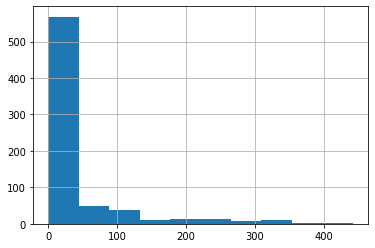

In [8]:
df['MIC'].hist()

In [9]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [10]:
df

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008,23.248994


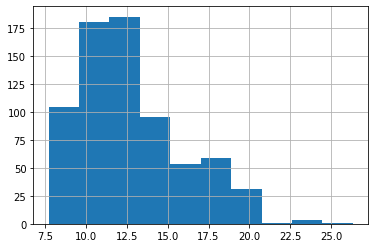

In [11]:
df['pIC50'].hist()

In [12]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [13]:
aa_freq = reduce_by_kmer_frequency(df)

In [14]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1154.66sequence/s]


In [15]:
physicochemical_prop = get_physicochemical_properties(df)

In [16]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [17]:
y = df[['pIC50', 'MIC']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [22]:
from sklearn.model_selection import cross_val_score

In [89]:
knn = KNeighborsRegressor(metric="euclidean", n_neighbors=3, weights="uniform")
cv_score = cross_val_score(knn, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()

In [90]:
cv_score, cv_mean

(array([-15.09302863, -14.02471584, -15.91168851, -12.77288717,
        -16.73829458]),
 -14.90812294749387)

In [91]:
_ = knn.fit(X_train, y_train_pmic)
y_pred = knn.predict(X_test)

In [92]:
mean_absolute_percentage_error(y_test_pmic, y_pred)

14.389302590641343

In [93]:
from scipy.stats import pearsonr

In [94]:
pearsonr(y_test_pmic, y_pred)

(0.7054017033790294, 7.936375422266976e-23)

In [95]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [96]:
list(zip(y_test_pmic, y_pred, ape))

[(14.051232891485345, 14.087530843119394, 0.25832574204961534),
 (12.557049568354268, 11.856457733860458, 5.579271075423732),
 (10.658510136814161, 11.131542377575402, 4.438070937582557),
 (11.250561200502737, 14.710614129341849, 30.754491862010376),
 (13.122363377404328, 15.774889178564601, 20.21378104593348),
 (13.112413046551161, 13.598068829284378, 3.7037864884904157),
 (10.819778284410283, 11.452151612705578, 5.84460523748857),
 (10.747457622830657, 10.844080541346313, 0.8990304675442669),
 (9.210340371976184, 9.847413341731311, 6.916931883359228),
 (13.122363377404328, 14.984363190404267, 14.189515710303793),
 (8.740336742730447, 10.73781727164905, 22.85358777028764),
 (9.819146404102378, 12.078433713908902, 23.00899912096848),
 (9.210340371976184, 10.235265532274331, 11.127983537032284),
 (18.7773556878911, 18.47112562680829, 1.6308476346341205),
 (14.331348723553809, 17.86946535491956, 24.687952959729436),
 (17.46516929892493, 16.163139875622154, 7.455006023806042),
 (9.0448259

In [97]:
np.exp(-14.051232891485345)/1e-6, np.exp(-13.284882306902103)/1e-6

(0.7899999999999994, 1.7000000000000008)

In [ ]:
11.2506, 15.9774

In [98]:
abs(0.7899999999999994-1.7000000000000008)/0.7899999999999994

1.151898734177218

In [223]:
np.exp(-15.9774)/1e-6, y_test_mic.iloc[0]

(0.11510742663184306, 0.79)

In [224]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [105]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [106]:
list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(14.0512, 14.0875, 0.25832574204961534, 0.79, 0.7618, 3.564707985478703),
 (12.557, 11.8565, 5.579271075423732, 3.52, 7.0926, 101.49448685309835),
 (10.6585, 11.1315, 4.438070937582557, 23.5, 14.6431, 37.68900186863309),
 (11.2506, 14.7106, 30.754491862010376, 13.0, 0.4086, 96.85719014784256),
 (13.1224, 15.7749, 20.21378104593348, 2.0, 0.1409, 92.95270126793511),
 (13.1124, 13.5981, 3.7037864884904157, 2.02, 1.2429, 38.470643446458254),
 (10.8198, 11.4522, 5.84460523748857, 20.0, 10.6266, 46.86707154086949),
 (10.7475, 10.8441, 0.8990304675442669, 21.5, 19.5198, 9.210170676980228),
 (9.2103, 9.8474, 6.916931883359228, 100.0, 52.8838, 47.11619140879051),
 (13.1224, 14.9844, 14.189515710303793, 2.0, 0.3107, 84.46383747023069),
 (8.7403, 10.7378, 22.85358777028764, 160.0, 21.7083, 86.43233135337927),
 (9.8191, 12.0784, 23.00899912096848, 54.4, 5.6807, 89.55751191705386),
 (9.2103, 10.2353, 11.127983537032284, 100.0, 35.8823, 64.11766813687208),
 (18.7774, 18.4711, 1.6308476346341205, 0.

In [58]:
ape.mean()

89750.42544692036

### SVR

In [208]:
svr = SVR(C=100, gamma=5)
cv_score = cross_val_score(svr, X_train, y_train_pmic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

_ = svr.fit(X_train, y_train_pmic)
y_pred = svr.predict(X_test)

print(np.std(y_train_pmic), np.std(y_pred))

[-14.059795   -12.792847   -15.97331154 -12.55099558 -15.41132159] -14.157654142956716
3.1492058039552058 2.7600725705898697


In [209]:
mean_absolute_percentage_error(y_test_pmic, y_pred)

13.495695137877838

In [225]:
from scipy.stats import pearsonr, spearmanr

In [211]:
pearsonr(y_test_pmic, y_pred)

(0.696186785551254, 4.812007547815509e-22)

In [212]:
ape = 100*np.abs(y_test_pmic-y_pred)/y_test_pmic

In [213]:
list(zip(y_test_pmic, y_pred, ape))

[(14.051232891485345, 13.256804347505762, 5.653799564171943),
 (12.557049568354268, 13.064114288902452, 4.038088069876438),
 (10.658510136814161, 10.598687261550657, 0.561268643512178),
 (11.250561200502737, 15.977432800095318, 42.014540566930634),
 (13.122363377404328, 14.280644563801022, 8.826772686322364),
 (13.112413046551161, 11.549079342855682, 11.922547727450274),
 (10.819778284410283, 11.278478400506817, 4.239459479104608),
 (10.747457622830657, 11.909038504003503, 10.807959630427549),
 (9.210340371976184, 9.735319956445608, 5.699893416173323),
 (13.122363377404328, 13.646315794997602, 3.9928205196289404),
 (8.740336742730447, 12.081593569450737, 38.228010259436466),
 (9.819146404102378, 11.489367410513596, 17.009839121182775),
 (9.210340371976184, 9.413205399097336, 2.2025790462467514),
 (18.7773556878911, 18.785093049674984, 0.04120581147043376),
 (14.331348723553809, 17.899144410569257, 24.895044812856423),
 (17.46516929892493, 13.21320202356381, 24.345411158555738),
 (9.044

In [150]:
ape.mean()

13.565334422357056

In [215]:
y_pred_mic = np.exp(-y_pred)/1e-6

In [216]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [217]:
list(zip(y_test_pmic.round(4), y_pred.round(4), ape, y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(14.0512, 13.2568, 5.653799564171943, 0.79, 1.7484, 121.31759026718474),
 (12.557, 13.0641, 4.038088069876438, 3.52, 2.12, 39.773920942683695),
 (10.6585, 10.5987, 0.561268643512178, 23.5, 24.9487, 6.164848568245826),
 (11.2506, 15.9774, 42.014540566930634, 13.0, 0.1151, 99.11458729877542),
 (13.1224, 14.2806, 8.826772686322364, 2.0, 0.6281, 68.59745314705424),
 (13.1124, 11.5491, 11.922547727450274, 2.02, 9.6449, 377.47122182897203),
 (10.8198, 11.2785, 4.239459479104608, 20.0, 12.6421, 36.789522547318185),
 (10.7475, 11.909, 10.807959630427549, 21.5, 6.7293, 68.70090119950191),
 (9.2103, 9.7353, 5.699893416173323, 100.0, 59.1567, 40.84325585932776),
 (13.1224, 13.6463, 3.9928205196289404, 2.0, 1.1844, 40.782460793251666),
 (8.7403, 12.0816, 38.228010259436466, 160.0, 5.6628, 96.46075524171269),
 (9.8191, 11.4894, 17.009839121182775, 54.4, 10.2384, 81.17945335726371),
 (9.2103, 9.4132, 2.2025790462467514, 100.0, 81.6388, 18.36115757145234),
 (18.7774, 18.7851, 0.04120581147043376, 0.

In [241]:
import matplotlib.pyplot as plt

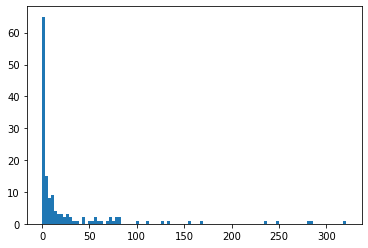

In [245]:
_ = plt.hist(y_pred_mic, bins=100)

In [246]:
ape_mic.argmax()

65

In [249]:
df.iloc[693,:]

Sequence    AGDDQGLDKCVPNSKEK
MIC                   3.7e-06
pIC50                 26.3227
Name: 693, dtype: object

In [ ]:
spearmanr(ape_mic, ape)

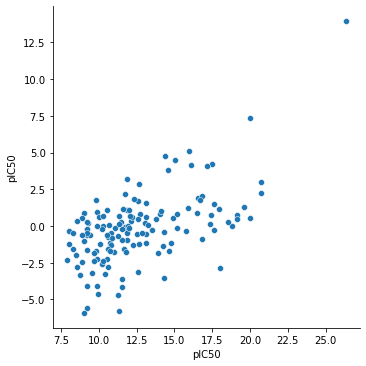

In [235]:
sns.relplot(x=y_test_pmic, y=(y_test_pmic-y_pred))

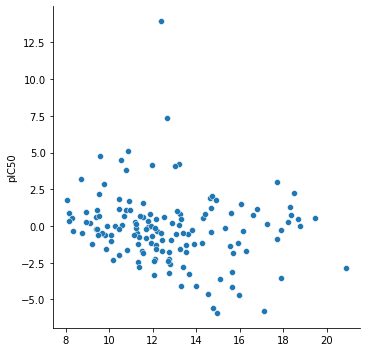

In [238]:
sns.relplot(x=y_pred, y=(y_test_pmic-y_pred))

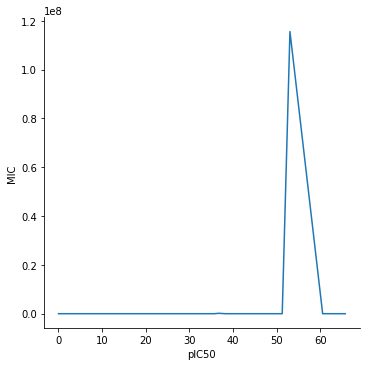

In [233]:
sns.relplot(x=ape, y=ape_mic, kind='line')

In [221]:
list(zip(ape_mic, ape))

[(121.31759026718474, 5.653799564171943),
 (39.773920942683695, 4.038088069876438),
 (6.164848568245826, 0.561268643512178),
 (99.11458729877542, 42.014540566930634),
 (68.59745314705424, 8.826772686322364),
 (377.47122182897203, 11.922547727450274),
 (36.789522547318185, 4.239459479104608),
 (68.70090119950191, 10.807959630427549),
 (40.84325585932776, 5.699893416173323),
 (40.782460793251666, 3.9928205196289404),
 (96.46075524171269, 38.228010259436466),
 (81.17945335726371, 17.009839121182775),
 (18.36115757145234, 2.2025790462467514),
 (0.7707505452901163, 0.04120581147043376),
 (97.17820135509652, 24.895044812856423),
 (6924.34647460967, 24.345411158555738),
 (137.74962068186252, 9.575064532519557),
 (436.0771224990005, 13.328754724110505),
 (5.36414780768637, 0.4697807623448795),
 (61.53786603551727, 8.030330711716509),
 (23.334746931171285, 1.9649835802700324),
 (53.303782453706795, 7.175388155865768),
 (14.96755538923224, 1.0679572951437128),
 (33.00681207658373, 2.802518244895